### 3.2. 线性回归的从零开始实现

In [32]:
%matplotlib inline
import random
import torch
from d2l import torch as d2l

#### 3.2.1 生成数据集

In [33]:
def synthetic_data(w, b, num_examples):  #@save
    """生成y=Xw+b+噪声"""
    X = torch.normal(0, 1, (num_examples, len(w)))  # 返回一个正态分布(0, 1)
    y = torch.matmul(X, w) + b  # 两个向量的矩阵乘法
    y += torch.normal(0, 0.01, y.shape) # 噪声
    return X, y.reshape((-1, 1))

true_w = torch.tensor([2, -3.4])    # 旨在产生 y = w1x1 + w2x2 + b + 噪声的函数
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)
print(f'x = {features.shape}, y = {labels.shape}')

x = torch.Size([1000, 2]), y = torch.Size([1000, 1])


In [34]:
print('features:', features[0],'\nlabel:', labels[0])

features: tensor([-0.4415,  0.8836]) 
label: tensor([0.3164])


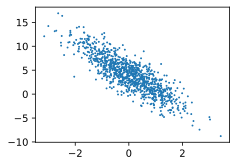

In [35]:
d2l.set_figsize()
d2l.plt.scatter(features[:, 1].detach().numpy(), labels.detach().numpy(), 1)

#### 3.2.2. 读取数据集

In [36]:
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    # 这些样本是随机读取的，没有特定的顺序
    random.shuffle(indices)
    for i in range(0, num_examples, batch_size):
        batch_indices = torch.tensor(
            indices[i: min(i + batch_size, num_examples)])
        yield features[batch_indices], labels[batch_indices]    # 优化内存，每执行一次函数，才返回一次数据

In [37]:
batch_size = 10

for X, y in data_iter(batch_size, features, labels):
    print(X, '\n', y)
    break

tensor([[-0.4723,  0.2448],
        [ 0.4917,  0.8440],
        [-0.6852,  0.6552],
        [-0.9308, -0.5159],
        [ 0.1543, -1.1595],
        [ 0.3044, -0.1166],
        [ 0.7980,  0.2288],
        [ 0.9692, -0.7958],
        [ 0.5057, -0.6098],
        [-0.3633, -0.7220]]) 
 tensor([[2.4227],
        [2.3141],
        [0.5909],
        [4.0908],
        [8.4684],
        [5.1898],
        [5.0232],
        [8.8492],
        [7.2847],
        [5.9368]])


#### 3.2.3. 初始化模型参数

In [38]:
w = torch.normal(0, 0.01, size=(2,1), requires_grad=True)   # 分别给网络第一层的两个节点分配权值w1,w2
b = torch.zeros(1, requires_grad=True)
print(f'w = {w}, b = {b}')

w = tensor([[0.0124],
        [0.0194]], requires_grad=True), b = tensor([0.], requires_grad=True)


#### 3.2.4. 定义模型

In [39]:
def linreg(X, w, b):  #@save，线性回归模型
    """线性回归模型"""
    return torch.matmul(X, w) + b  # 矩阵乘法

#### 3.2.5. 定义损失函数

In [40]:
def squared_loss(y_hat, y):  #@save, MSE
    """均方损失"""
    return (y_hat - y.reshape(y_hat.shape)) ** 2 / 2    # y是真实标签

#### 3.2.6. 定义优化算法

In [48]:
def sgd(params, lr, batch_size):  #@save, params = [w, b]
    # print(f'params = {params}')
    """小批量随机梯度下降"""
    with torch.no_grad():   # 在求导过一次之后把参数的requires_grad=False，只求导一次，节省内存
        for param in params:
            param -= lr * param.grad / batch_size   # 这里传进来的params是
            param.grad.zero_()

#### 3.2.7. 训练

In [51]:
lr = 0.03
num_epochs = 3
net = linreg
loss = squared_loss
print(f'ori: w = {w}, b = {b}')

for epoch in range(num_epochs):
    i = 0
    for X, y in data_iter(batch_size, features, labels):    # 总的数据集格式X = (100, 10, 2), y = (100, 10, 1)
        # l.shape = (10, 1)
        l = loss(net(X, w, b), y)  # X和y的小批量损失，这里计算了一个batch_size = 10个样本的损失，
        # print(f'l = {l.shape}')
        # 因为l形状是(batch_size,1)，而不是一个标量。l中的所有元素被加到一起，
        # 并以此计算关于[w,b]的梯度
        # 在计算图中，l和w,b相关，所以自动微分会计算出w,b的梯度，而这里l.sum计算了所有损失的和，在计算w的梯度时，就是10个样本dw的和，所以在梯度下降时，dw/10
        # 即 l = W1X+W2X+...+W10X
        l.sum().backward() 
        # print(f'w = {w}, b = {b}')
        print(f'w.shape = {w.shape}')
        sgd([w, b], lr, batch_size)  # 使用参数的梯度更新参数，得到新的w -= lr*(w.grad)
    with torch.no_grad():
        train_l = loss(net(features, w, b), labels) # 更新好的w,b
        print(f'epoch {epoch + 1}, loss {float(train_l.mean()):f}')

ori: w = tensor([[ 1.9999],
        [-3.4004]], requires_grad=True), b = tensor([4.2002], requires_grad=True)
l = torch.Size([10, 1])
w.shape = torch.Size([2, 1])
l = torch.Size([10, 1])
w.shape = torch.Size([2, 1])
l = torch.Size([10, 1])
w.shape = torch.Size([2, 1])
l = torch.Size([10, 1])
w.shape = torch.Size([2, 1])
l = torch.Size([10, 1])
w.shape = torch.Size([2, 1])
l = torch.Size([10, 1])
w.shape = torch.Size([2, 1])
l = torch.Size([10, 1])
w.shape = torch.Size([2, 1])
l = torch.Size([10, 1])
w.shape = torch.Size([2, 1])
l = torch.Size([10, 1])
w.shape = torch.Size([2, 1])
l = torch.Size([10, 1])
w.shape = torch.Size([2, 1])
l = torch.Size([10, 1])
w.shape = torch.Size([2, 1])
l = torch.Size([10, 1])
w.shape = torch.Size([2, 1])
l = torch.Size([10, 1])
w.shape = torch.Size([2, 1])
l = torch.Size([10, 1])
w.shape = torch.Size([2, 1])
l = torch.Size([10, 1])
w.shape = torch.Size([2, 1])
l = torch.Size([10, 1])
w.shape = torch.Size([2, 1])
l = torch.Size([10, 1])
w.shape = torch.Si

下面的代码测试了梯度在 h = wx + b 中的传播。
- 网络结构：输入两个节点，输出一个节点
- 初始化两个节点的输入X = [1, 2]，两个节点的权值相同 w = 0.5, b = 0
- 下面y_hat.sum.backward()的计算：sum(dw) = sum(x=[1, 2]) = 3, sum(db) = sum(1(db = 1)) = 1
- 很明显这是两个节点中dw的和，所以dw/2，当成一个节点的梯度，去更新一个节点的w = lr * dw / 2

In [89]:
# 测试梯度计算
from turtle import forward
# from torchviz import make_dot
import numpy as np

def h(x, w, b):
    return w  * x + 2*b

def loss(y_hat, y):  #@save, MSE
    """均方损失"""
    return (y_hat - y.reshape(y_hat.shape)) ** 2 / 2    # y是真实标签
        
net = h
X = torch.tensor([1.0, 2.0])
y_truth = torch.tensor([1.0, 2.0])
# w, b = 0.5, 0
w = torch.tensor(0.5, requires_grad=True)
b = torch.tensor(0.0, requires_grad=True)
y_hat = net(X, w, b)

print(f'y_hat = {y_hat}, y_truth = {y_truth}')
y_hat.sum().backward()
# with torch.no_grad: 
print(f'w_grad = {w.grad}, b_grad = {b.grad}')

y_hat = tensor([0.5000, 1.0000], grad_fn=<AddBackward0>), y_truth = tensor([1., 2.])
w_grad = 3.0, b_grad = 4.0
